In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms.functional as F

import cv2 as cv
import numpy as np
import time
import os
import logging
import sys
import json
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from tqdm import tqdm

# pv_vision_dir = os.path.join(Path.home(), 'pv-vision')
pv_vision_dir = os.path.join("/home/eccoope", "pv-vision")
# functions_dir = os.path.join(Path.home(), 'el_img_cracks_ec', 'scripts')
functions_dir = os.path.join("/home/eccoope", "el_img_cracks_ec", "scripts")

sys.path.append(pv_vision_dir)
sys.path.append(functions_dir)

# ojas_functions_dir = os.path.join(Path.home(), 'pvcracks/retrain/')
ojas_functions_dir = "/Users/ojas/Desktop/saj/SANDIA/pvcracks/retrain/"
sys.path.append(ojas_functions_dir)

from utils.unet_model import construct_unet
import functions

In [3]:
# root = Path('/projects/wg-psel-ml/EL_images/osanghi/CornersIHDEANE/')
# root = Path('/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CornersIHDEANE/')
# root = Path('/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Norman_LineCorners/')
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/LineCorners_With_Original/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CWRU_SunEdison_Mono/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CWRU_Dupont_Mono/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_SunEdison_and_Dupont_Mono/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/LBNL_Mono_Cells/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_SE_Dupont_and_LBNL_Mono/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_LBNL_ASU_No_Busbar/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_LBNL_ASU_Overlap/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_LBNL_ASU_Combined_Overlap_NoOverlap/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_ASU/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CWRU_Dupont_Mono_ContinuousCracks/"
root = (
    "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_ASU_ContinuousCracks/"
)


model_weight_paths = {
    "emma_retrained": "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/retrained_pv-vision_model.pt",
    "original": "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/pv-vision_model.pt",
}

# weight_path = model_weight_paths["emma_retrained"]
weight_path = model_weight_paths["original"]

# checkpoint_name = "line_corners_og_weights_checkpoint"
# checkpoint_name = "CWRU_SunEdison_Mono"
# checkpoint_name = "CWRU_Dupont_Mono"
# checkpoint_name = "Combined_CWRU_SunEdison_and_Dupont_Mono"
# checkpoint_name = "LBNL_Mono_Cells"
# checkpoint_name = "Combined_CWRU_LBNL_ASU_No_Busbar"
# checkpoint_name = "Combined_CWRU_LBNL_ASU_Overlap"
# checkpoint_name = "Combined_CWRU_LBNL_ASU_Combined_Overlap_NoOverlap"
# checkpoint_name = "Combined_CWRU_ASU"
# checkpoint_name = "CWRU_Dupont_Mono_ContinuousCracks"
checkpoint_name = "Combined_CWRU_ASU_ContinuousCracks"

In [4]:
def load_dataset(root):
    transformers = functions.Compose(
        [functions.FixResize(256), functions.ToTensor(), functions.Normalize()]
    )

    train_dataset = functions.SolarDataset(
        root, image_folder="img/train", mask_folder="ann/train", transforms=transformers
    )

    val_dataset = functions.SolarDataset(
        root, image_folder="img/val", mask_folder="ann/val", transforms=transformers
    )

    return train_dataset, val_dataset

In [5]:
def load_device_and_model(weight_path):
    # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device = torch.device("mps")
    unet = construct_unet(5)
    unet = torch.nn.DataParallel(unet)

    # checkpoint = torch.load(weight_path, map_location=device)
    # from collections import OrderedDict

    # new_state_dict = OrderedDict()
    # if weight_path == model_weight_paths["emma_retrained"]:
    #     for k, v in checkpoint.items():
    #         name = "module." + k
    #         new_state_dict[name] = v
    # elif weight_path == model_weight_paths["original"]:
    #     for k, v in checkpoint.items():
    #         new_state_dict[k] = v

    # unet.load_state_dict(new_state_dict)

    model = unet.module.to(device)

    return device, model

In [6]:
def get_save_dir(base_dir, checkpoint_name):
    checkpoint_dir = base_dir + "/checkpoints/"
    folders = [folder for folder in os.listdir(checkpoint_dir)]

    max_number = 0
    for folder in folders:
        number = int(folder[-1])
        if number > max_number:
            max_number = number

    new_folder_name = f"{checkpoint_name}{max_number + 1}"
    new_folder_path = os.path.join(checkpoint_dir, new_folder_name)

    os.makedirs(new_folder_path, exist_ok=True)

    return new_folder_path

In [7]:
train_dataset, val_dataset = load_dataset(root)
device, model = load_device_and_model(weight_path)

In [8]:
batch_size_val = 1
batch_size_train = 1
lr = 0.000001
step_size = 1
gamma = 0.1
num_epochs = 30
criterion = torch.nn.SmoothL1Loss()

save_dir = get_save_dir(str(root), checkpoint_name)
os.makedirs(save_dir, exist_ok=True)

params_dict = {
    "batch_size_val": batch_size_val,
    "batch_size_train": batch_size_train,
    "lr": lr,
    "step_size": step_size,
    "gamma": gamma,
    "num_epochs": num_epochs,
    "criterion": str(criterion),
}

with open(os.path.join(save_dir, "params.json"), "w", encoding="utf-8") as f:
    json.dump(params_dict, f, ensure_ascii=False, indent=4)


train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False)

In [9]:
optimizer = Adam(model.parameters(), lr=lr)
lr_scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
evaluate_metric = None
running_record = {"train": {"loss": []}, "val": {"loss": []}}

save_name = "model.pt"
cache_output = True

In [10]:
# category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "corner"}
# category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "non-cell area"}
category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "non-cell"}
# category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "non-cell", 5: "overlap"}

In [11]:
def inference_and_show(idx, retrained=False):
    img, mask = train_loader.dataset.__getitem__(idx)
    img = img.to(device)
    raw_img, _ = train_loader.dataset.__getraw__(idx)
    test_res = (
        model(img.unsqueeze(0)).detach().cpu().numpy().squeeze()
    )  # .argmax(axis = 0)
    test_res = np.argmax(test_res, axis=0)

    mask_cpu = mask.cpu().numpy()

    cmap = mpl.colormaps["viridis"].resampled(5)  # define the colormap
    cmaplist = [cmap(i) for i in range(5)]
    # cmap = mpl.colormaps['viridis'].resampled(6)  # define the colormap
    # cmaplist = [cmap(i) for i in range(6)]

    fig, ax = plt.subplots(ncols=3, figsize=(12, 12))

    im = ax[0].imshow(raw_img.convert("L"), cmap="gray", interpolation="None")
    ax[0].axis("off")

    clim = (0, 4)
    # clim = (0, 5)
    im = ax[1].imshow(mask_cpu, cmap="viridis", clim=clim)
    ax[1].axis("off")
    ax[1].set_title("Ground Truth Mask")

    ax[2].imshow(test_res, cmap="viridis", clim=clim, interpolation="None")
    handles, labels = ax[2].get_legend_handles_labels()

    for c, classlabel in zip(
        cmaplist, [f"({k}) {v}" for k, v in category_mapping.items()]
    ):
        patch = mpatches.Patch(color=c, label=classlabel, ec="k")
        handles.append(patch)
    ax[2].legend(handles=handles, fontsize="x-small")
    ax[2].axis("off")
    if retrained:
        ax[2].set_title("Retrained Model Prediction")
    else:
        ax[2].set_title("Model Prediction")

# Training

In [12]:
training_epoch_loss = []
val_epoch_loss = []

for epoch in tqdm(range(1, num_epochs + 1)):
    training_step_loss = []

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)

        output_activated = 1 / (1 + torch.exp(-output))
        target_onehot = torch.nn.functional.one_hot(target, num_classes=5)
        target_onehot = torch.moveaxis(target_onehot, 3, 1)

        training_loss = criterion(output_activated, target_onehot.float())
        training_loss.backward()
        optimizer.step()
        training_step_loss.append(training_loss.item())

    training_epoch_loss.append(np.array(training_step_loss).mean())

    val_step_loss = []

    for batch_idx, (data, target) in enumerate(val_loader):
        data, target = data.to(device), target.to(device)
        data = data.to(device)

        output = model(data)
        output_activated = 1 / (1 + torch.exp(-output))
        target_onehot = torch.nn.functional.one_hot(target, num_classes=5)
        target_onehot = torch.moveaxis(target_onehot, 3, 1)
        val_loss = criterion(output_activated, target_onehot.float())

        val_step_loss.append(val_loss.item())

    val_epoch_loss.append(np.array(val_step_loss).mean())

    os.makedirs(os.path.join(save_dir, f"epoch_{epoch}"), exist_ok=True)
    torch.save(model.state_dict(), os.path.join(save_dir, f"epoch_{epoch}", save_name))
    # logger.info(f'Saved model at epoch {epoch}')
    print(f"Saved model at epoch {epoch}")

  3%|▎         | 1/30 [04:31<2:11:14, 271.52s/it]

Saved model at epoch 1


  7%|▋         | 2/30 [09:18<2:11:04, 280.87s/it]

Saved model at epoch 2


 10%|█         | 3/30 [13:52<2:04:48, 277.33s/it]

Saved model at epoch 3


 13%|█▎        | 4/30 [18:25<1:59:34, 275.95s/it]

Saved model at epoch 4


 17%|█▋        | 5/30 [22:59<1:54:37, 275.10s/it]

Saved model at epoch 5


 20%|██        | 6/30 [27:35<1:50:06, 275.26s/it]

Saved model at epoch 6


 23%|██▎       | 7/30 [32:06<1:45:03, 274.05s/it]

Saved model at epoch 7


 27%|██▋       | 8/30 [36:37<1:40:05, 272.97s/it]

Saved model at epoch 8


 30%|███       | 9/30 [41:07<1:35:17, 272.25s/it]

Saved model at epoch 9


 33%|███▎      | 10/30 [45:37<1:30:29, 271.50s/it]

Saved model at epoch 10


 37%|███▋      | 11/30 [50:06<1:25:44, 270.78s/it]

Saved model at epoch 11


 40%|████      | 12/30 [54:36<1:21:07, 270.43s/it]

Saved model at epoch 12


 43%|████▎     | 13/30 [59:05<1:16:28, 269.90s/it]

Saved model at epoch 13


 47%|████▋     | 14/30 [1:03:34<1:11:55, 269.69s/it]

Saved model at epoch 14


 50%|█████     | 15/30 [1:08:02<1:07:20, 269.34s/it]

Saved model at epoch 15


 53%|█████▎    | 16/30 [1:12:32<1:02:51, 269.37s/it]

Saved model at epoch 16


 57%|█████▋    | 17/30 [1:17:01<58:19, 269.16s/it]  

Saved model at epoch 17


 60%|██████    | 18/30 [1:21:29<53:48, 269.01s/it]

Saved model at epoch 18


 63%|██████▎   | 19/30 [1:25:58<49:18, 268.94s/it]

Saved model at epoch 19


 67%|██████▋   | 20/30 [1:30:27<44:48, 268.85s/it]

Saved model at epoch 20


 70%|███████   | 21/30 [1:34:56<40:21, 269.06s/it]

Saved model at epoch 21


 73%|███████▎  | 22/30 [1:39:25<35:50, 268.84s/it]

Saved model at epoch 22


 77%|███████▋  | 23/30 [1:43:51<31:16, 268.14s/it]

Saved model at epoch 23


 80%|████████  | 24/30 [1:48:14<26:40, 266.72s/it]

Saved model at epoch 24


 83%|████████▎ | 25/30 [1:52:37<22:07, 265.59s/it]

Saved model at epoch 25


 87%|████████▋ | 26/30 [1:57:01<17:39, 264.98s/it]

Saved model at epoch 26


 90%|█████████ | 27/30 [2:01:25<13:14, 264.70s/it]

Saved model at epoch 27


 93%|█████████▎| 28/30 [2:05:48<08:48, 264.32s/it]

Saved model at epoch 28


 97%|█████████▋| 29/30 [2:10:12<04:24, 264.07s/it]

Saved model at epoch 29


100%|██████████| 30/30 [2:14:36<00:00, 269.22s/it]

Saved model at epoch 30


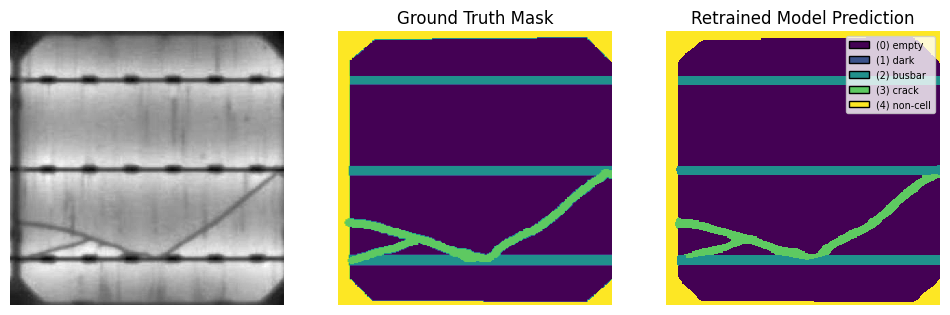

In [13]:
inference_and_show(-32, retrained=True)

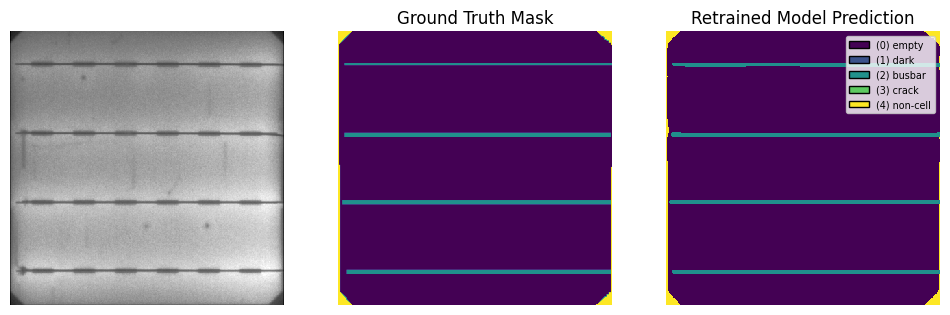

In [14]:
inference_and_show(13, retrained=True)

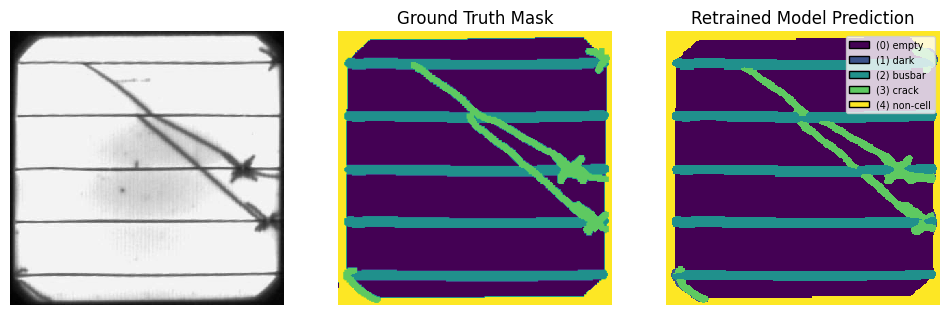

In [15]:
inference_and_show(44, retrained=True)

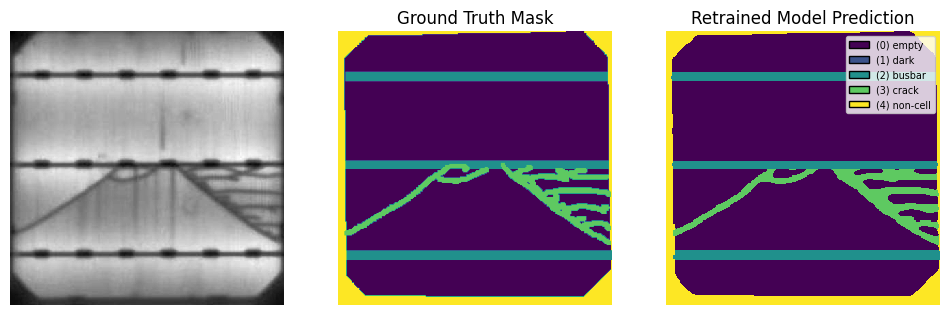

In [16]:
inference_and_show(1, retrained=True)

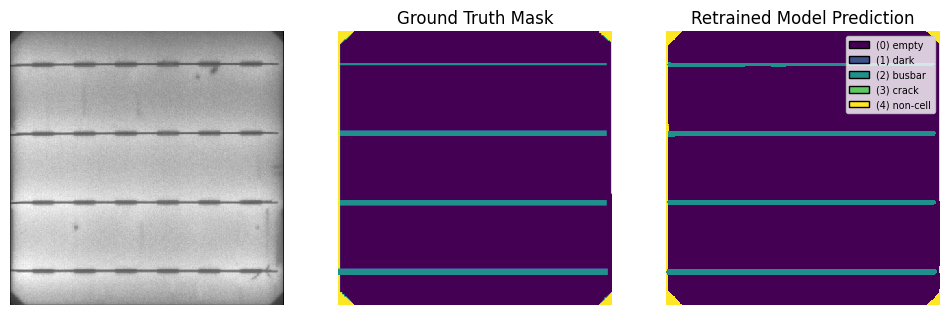

In [17]:
inference_and_show(6, retrained=True)

In [18]:
# for i in range(500):
#     inference_and_show(i, retrained=True)

[np.float64(0.0975581129161885), np.float64(0.07597738156874721), np.float64(0.06858599318054537), np.float64(0.06297725021315459), np.float64(0.05846628307288511), np.float64(0.05484501564631256), np.float64(0.05162074096715107), np.float64(0.048623663562729846), np.float64(0.04579484974915862), np.float64(0.0431055371769574), np.float64(0.040552847015971956), np.float64(0.038122836879282966), np.float64(0.035797718490837925), np.float64(0.03357420106050464), np.float64(0.03146817901640876), np.float64(0.02947220890222393), np.float64(0.02758527002312219), np.float64(0.025806632877800603), np.float64(0.0241393675012028), np.float64(0.022563690136169916), np.float64(0.021086508717637856), np.float64(0.019702565235396225), np.float64(0.018409231774354228), np.float64(0.01720474824394646), np.float64(0.016086891710091703), np.float64(0.015044635533691404), np.float64(0.014081529241959793), np.float64(0.013179781933982596), np.float64(0.012338264602810716), np.float64(0.011558282868966412

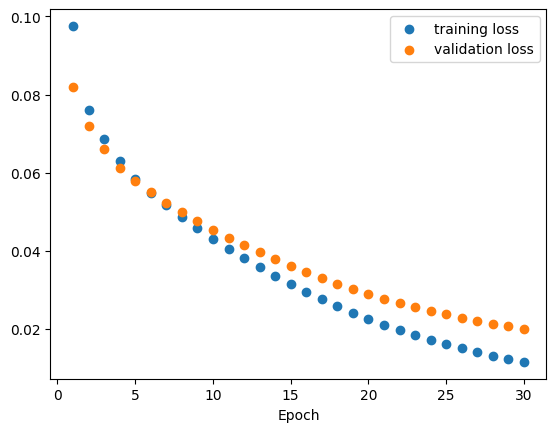

In [19]:
fig, ax = plt.subplots()

x = np.arange(1, len(training_epoch_loss) + 1, 1)

ax.scatter(x, training_epoch_loss, label="training loss")
ax.scatter(x, val_epoch_loss, label="validation loss")
ax.legend()
ax.set_xlabel("Epoch")

print(training_epoch_loss)

In [20]:
val_epoch_loss

[np.float64(0.08197728330239701),
 np.float64(0.07187081565158054),
 np.float64(0.06606618011483369),
 np.float64(0.061278979172007725),
 np.float64(0.057823412310772426),
 np.float64(0.05501286211771706),
 np.float64(0.052356878962046424),
 np.float64(0.04993770705958525),
 np.float64(0.047616117333356564),
 np.float64(0.04532916298784768),
 np.float64(0.043328462007898874),
 np.float64(0.04140397745032851),
 np.float64(0.03959381142363381),
 np.float64(0.03791122540783958),
 np.float64(0.03614040612043759),
 np.float64(0.03463880650211161),
 np.float64(0.033077285086480196),
 np.float64(0.03161465645300599),
 np.float64(0.030279457066267633),
 np.float64(0.028976600581464677),
 np.float64(0.027772486183090143),
 np.float64(0.02665029514057282),
 np.float64(0.02559367540521553),
 np.float64(0.024617509657558732),
 np.float64(0.02373620011983588),
 np.float64(0.022879837162661763),
 np.float64(0.02209112150505328),
 np.float64(0.021369998432553043),
 np.float64(0.020708694688071266),
 